In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import tqdm
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import imutils

import random

from PIL import Image


np.random.seed(1234)

In [2]:
TEST_PREDICTIONS_FILENAME = "./baseline_test_predictions.pkl"
NUM_IMAGES_TO_SHOW = 16000
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [ ]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [ ]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

In [ ]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()

Найдем изображения с шумными лендмарками и выкинем их из трейна

In [11]:
TRAIN_IMGPATH = "./contest01_data/train/images/"

In [12]:
imgs = [f for f in listdir(TRAIN_IMGPATH) if isfile(join(TRAIN_IMGPATH, f))]

In [13]:
TRAIN_LANDMARK_FILE = "./contest01_data/train/landmarks.csv"

In [14]:
df_landmark_train = pd.read_csv(TRAIN_LANDMARK_FILE, delimiter='\t').set_index('file_name')

In [15]:
df_landmark_train.head()

,Point_0_X,Point_0_Y,Point_1_X,Point_1_Y,Point_2_X,Point_2_Y,Point_3_X,Point_3_Y,Point_4_X,Point_4_Y,...,Point_966_X,Point_966_Y,Point_967_X,Point_967_Y,Point_968_X,Point_968_Y,Point_969_X,Point_969_Y,Point_970_X,Point_970_Y
file_name,,,,,,,,,,,,,,,,,,,,,
07c5e48d938e8d82c0f10973d66183f3.jpg,162,311,159,311,156,311,152,311,149,311,...,125,254,124,254,123,254,112,163,191,166
28e70684d6e2d6d75a6d3a973e4d4d93.jpg,90,376,89,375,85,374,84,374,82,374,...,87,307,85,309,87,310,96,202,162,203
e7696776dc7b15ca3fa80d4332443e96.jpg,123,210,121,210,119,211,117,211,115,211,...,98,175,97,175,95,176,80,119,128,115
199668f481aa5794c28657bace02fd84.jpg,109,203,107,203,105,203,103,203,101,203,...,75,159,73,158,73,157,75,107,129,106
9ebb7d722fa1cece4fa0d7b2fd39b399.jpg,59,127,58,126,56,126,55,126,53,125,...,44,92,43,91,43,91,58,61,84,68


In [16]:
def angle_variation(ps):
    dps = np.diff(ps, axis=0)
    angles = []
    for i in range(len(dps) - 1):
        e1, e2 = dps[i], dps[i+1]
        x = np.clip(e1.dot(e2)/(np.linalg.norm(e1) * np.linalg.norm(e2) + 0.00001), -1, 1)
        angle = math.acos(x)*180/math.pi
        angles.append(angle)

    return np.mean(angles)


In [17]:
stats = []
for img in tqdm(imgs):
    img_landmark = df_landmark_train.loc[img].values.reshape(971, 2)
    stat1 = angle_variation(img_landmark[:64,:])
    stat2 = angle_variation(img_landmark[64:128,:])
    stats.append((img, stat1, stat2))
stats = np.array(stats)
stats = pd.DataFrame({'file': stats[:,0], 
                      'stat1': stats[:, 1].astype(float), 
                      'stat2': stats[:, 2].astype(float)})

100%|██████████| 64000/64000 [03:44<00:00, 285.51it/s]


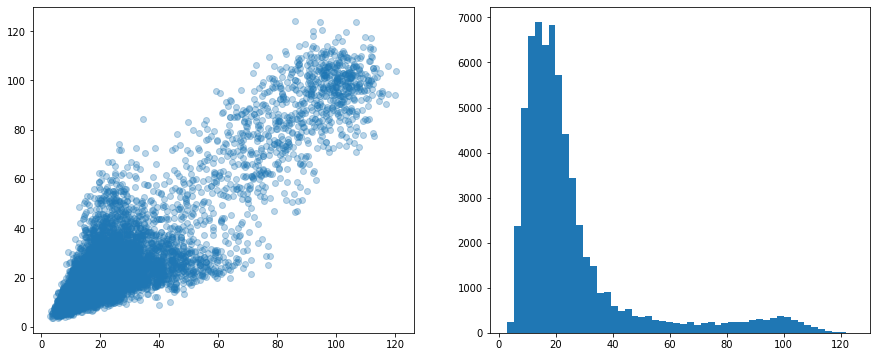

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].scatter(stats['stat1'].values[:10000], stats['stat2'].values[:10000], alpha=0.3)
axes[1].hist(stats['stat1'].values, bins=50)
plt.show()

In [19]:
smooth = stats[(stats['stat1'] < 40) & (stats['stat2'] < 40)].reset_index()
noisy = stats[(stats['stat1'] > 70) & (stats['stat2'] > 70)].reset_index()


In [20]:
def show_image(file, title, rad=1, ax=None):
    src = cv2.imread(TRAIN_IMGPATH + file)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    landmark = df_landmark_train.loc[file, :].values.reshape(971, 2)
    for i, (x, y) in enumerate(landmark):
        cv2.circle(src, (int(x), int(y)), rad, (0, 255, 0), -1)
        
    ax = ax or plt.gca()
    ax.set_title(title)
    ax.imshow(src)

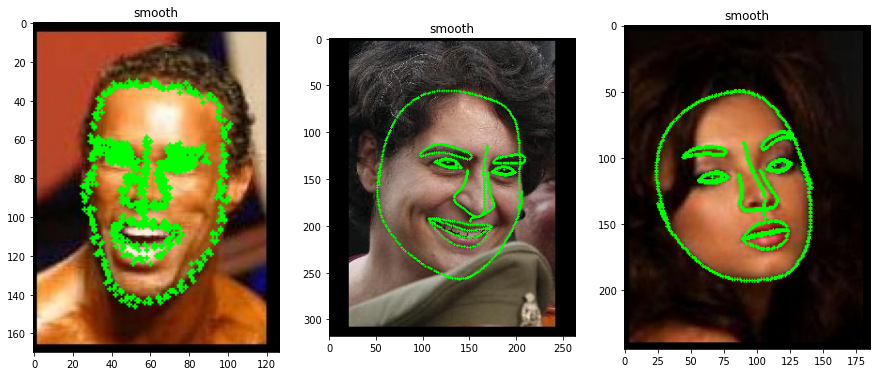

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

show_image(noisy['file'].values[160], title='smooth', rad=1, ax=axes[0])
show_image(smooth['file'].values[11], title='smooth', rad=1,ax=axes[1])
show_image(smooth['file'].values[12], title='smooth', rad=1,ax=axes[2])

In [22]:
noisy

,index,file,stat1,stat2
0,9,770e107c145d2e08d1a17721283b6006.jpg,76.257017,73.301790
1,13,b5b4b2d4da3f6fe21dc035bf798cae13.jpg,81.765510,103.721385
2,18,858557810e3239bd40f602330ec693a0.jpg,107.694928,98.471705
3,36,c8f50b1ea48fd3d402f1fc6900a7990d.jpg,75.129661,99.283850
4,42,2219c8c899731c3a325d98c44a1bdf4c.jpg,94.761926,109.433774
...,...,...,...,...
3987,63928,d75d582c7211805743d469e60addc95d.jpg,104.088487,94.403709
3988,63933,cac89870acc355196affe94d155d79ab.jpg,87.274750,80.714704
3989,63934,3cd8dbcddc5de070cd4232ff89bcb525.jpg,111.566388,83.709744
3990,63955,a8c7e2acd7b15542ce44648d8a27b5af.jpg,77.184203,91.307222


In [23]:
np.shape(smooth)

(53329, 4)

Разделим обучающую выборку на трейн и валидацию

In [24]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+math.cos(math.radians(angle)), -math.sin(math.radians(angle))], 
            [+math.sin(math.radians(angle)), +math.cos(math.radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        _image = TF.to_tensor(image)
        image = TF.resize(image, img_size)
        scale_matrix = torch.tensor([
            [224/_image.size()[2], 0], 
            [0, 224/_image.size()[1]]
        ])
        new_landmarks = np.matmul(landmarks, scale_matrix)
        return image, new_landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [25]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        self.image_filenames = list(smooth.file)
        self.landmarks = []
        self.transform = transform
       
        for img in tqdm(self.image_filenames):
            self.landmarks.append(df_landmark_train.loc[img, :].values.reshape(971, 2))
        
        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(TRAIN_IMGPATH ,self.image_filenames[index]), 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks)

        landmarks = landmarks - 0.5
        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

100%|██████████| 53329/53329 [00:05<00:00, 8941.51it/s]


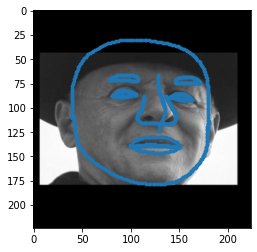

In [26]:
image, landmarks = dataset[27894]
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [27]:
image.size()

torch.Size([1, 224, 224])

## every day i'm shuffling

In [80]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 47997
The length of Valid set is 5332


In [29]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 971, 2])


In [30]:
class Network(nn.Module):
    def __init__(self,num_classes=1942):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=True)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.maxpool
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [31]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [32]:
import time 
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in tqdm(range(1,num_epochs+1)):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), './face_landmarks_2.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

  0%|          | 0/10 [00:00<?, ?it/s]

Valid Steps: 667/667  Loss: 4024.1794  
--------------------------------------------------
Epoch: 1  Train Loss: 8234.5540  Valid Loss: 4024.1794
--------------------------------------------------


 10%|█         | 1/10 [11:51<1:46:47, 711.97s/it]


Minimum Validation Loss of 4024.1794 at epoch 1/10
Model Saved

Valid Steps: 667/667  Loss: 651.8311  
--------------------------------------------------
Epoch: 2  Train Loss: 2001.4093  Valid Loss: 651.8311
--------------------------------------------------


 20%|██        | 2/10 [23:51<1:35:14, 714.27s/it]


Minimum Validation Loss of 651.8311 at epoch 2/10
Model Saved

Valid Steps: 633/667  Loss: 140.6600 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ykr2an9b'


Valid Steps: 667/667  Loss: 141.1981 
--------------------------------------------------
Epoch: 3  Train Loss: 326.1845  Valid Loss: 141.1981
--------------------------------------------------


 30%|███       | 3/10 [35:34<1:22:54, 710.71s/it]


Minimum Validation Loss of 141.1981 at epoch 3/10
Model Saved

Train Steps: 123/750  Loss: 141.9193 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-012glvb7'


Valid Steps: 667/667  Loss: 124.6836 
--------------------------------------------------
Epoch: 4  Train Loss: 120.5505  Valid Loss: 124.6836
--------------------------------------------------


 40%|████      | 4/10 [47:03<1:10:26, 704.38s/it]


Minimum Validation Loss of 124.6836 at epoch 4/10
Model Saved

Valid Steps: 667/667  Loss: 69.8640  
--------------------------------------------------
Epoch: 5  Train Loss: 89.9749  Valid Loss: 69.8640
--------------------------------------------------


 50%|█████     | 5/10 [58:37<58:25, 701.16s/it]  


Minimum Validation Loss of 69.8640 at epoch 5/10
Model Saved

Valid Steps: 667/667  Loss: 51.3842 
--------------------------------------------------
Epoch: 6  Train Loss: 56.9614  Valid Loss: 51.3842
--------------------------------------------------


 60%|██████    | 6/10 [1:10:11<46:36, 699.01s/it]


Minimum Validation Loss of 51.3842 at epoch 6/10
Model Saved

Valid Steps: 667/667  Loss: 45.5769 
--------------------------------------------------
Epoch: 7  Train Loss: 47.9882  Valid Loss: 45.5769
--------------------------------------------------


 70%|███████   | 7/10 [1:21:45<34:52, 697.56s/it]


Minimum Validation Loss of 45.5769 at epoch 7/10
Model Saved

Train Steps: 714/750  Loss: 31.8375 

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-scprazg9'


Valid Steps: 667/667  Loss: 20.3214 
--------------------------------------------------
Epoch: 8  Train Loss: 31.3607  Valid Loss: 20.3214
--------------------------------------------------


 80%|████████  | 8/10 [1:33:19<23:12, 696.39s/it]


Minimum Validation Loss of 20.3214 at epoch 8/10
Model Saved

Valid Steps: 667/667  Loss: 16.0138 
--------------------------------------------------
Epoch: 9  Train Loss: 19.6106  Valid Loss: 16.0138
--------------------------------------------------


 90%|█████████ | 9/10 [1:45:02<11:38, 698.58s/it]


Minimum Validation Loss of 16.0138 at epoch 9/10
Model Saved

Valid Steps: 42/667  Loss: 12.3445  

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-p8esc25p'


Valid Steps: 667/667  Loss: 12.8027 
--------------------------------------------------
Epoch: 10  Train Loss: 15.9548  Valid Loss: 12.8027
--------------------------------------------------


100%|██████████| 10/10 [1:56:56<00:00, 701.62s/it]


Minimum Validation Loss of 12.8027 at epoch 10/10
Model Saved

Training Complete
Total Elapsed Time : 7016.192340373993 s


In [33]:
torch.save(network.state_dict(), './face_landmarks_2.pth') 

## My predictions

In [82]:
TEST_IMGPATH = "./contest01_data/test/images/"

In [83]:
test_imgs = [f for f in listdir(TEST_IMGPATH) if isfile(join(TEST_IMGPATH, f))]

In [84]:
df_submission = []

In [85]:
images = []
transition_matrices = []

for test_img in tqdm(test_imgs):
    image = cv2.imread(os.path.join(TEST_IMGPATH ,test_img), 0)
    image = Image.fromarray(image)
    image = TF.to_tensor(image)
    transition_matrices.append(torch.tensor([
        [224./ image.size()[2], 0], 
        [0, 224./image.size()[1]]
    ]))
    image = TF.resize(image, (224, 224))
    image = TF.normalize(image, [0.5], [0.5])
    images.append(image)

preds = []
with torch.no_grad():
    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('./face_landmarks_4.pth')) 
    best_network.eval()
    for i in tqdm(range(320)):
        image_tensor = torch.stack(images[50*i:50*(i+1)])
        preds.append(best_network(image_tensor.cuda()).cpu() + 0.5)
        del image_tensor

100%|██████████| 320/320 [00:17<00:00, 18.82it/s]


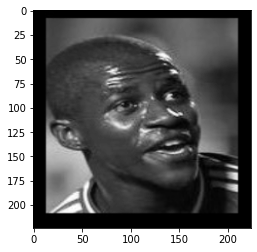

In [86]:
plt.imshow(images[2444].numpy().squeeze(), cmap='gray');

In [87]:
real_preds = []
for i in range(len(preds)):
    for j in range(50):
        real_preds.append(np.matmul(preds[i][j].reshape(971, 2), np.linalg.inv(transition_matrices[50*i + j])))

In [88]:
len(real_preds)

16000

In [89]:
real_preds[0]

tensor([[140.0644, 256.9488],
        [137.7611, 257.2029],
        [135.4580, 257.0019],
        ...,
        [114.6715, 211.7294],
        [103.8770, 138.8855],
        [164.5219, 134.9881]])

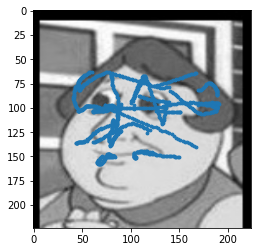

In [95]:
i = 197
# image = cv2.imread(os.path.join(TEST_IMGPATH ,test_imgs[i]), 0)
# image = Image.fromarray(image)
# image = TF.to_tensor(image)
image = images[i]
plt.imshow(image.numpy().squeeze(), cmap='gray');
# plt.scatter(real_preds[1098][:,0], real_preds[1098][:,1], s=8);
plt.scatter(preds[3][47][:971], preds[3][47][971:], s=8);

In [96]:
len(preds[201][48])

1942

In [97]:
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"

In [98]:
def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data, "contest01_data/test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        k = test_imgs.index(file_name)
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[k]
        needed_points = points_for_image[point_index_list].numpy().astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

In [99]:
create_submission(path_to_data='.', test_predictions=real_preds, path_to_submission_file="my_submission4.csv")

In [50]:
real_preds[1098]

tensor([[153.8618, 271.1320],
        [151.4521, 271.5253],
        [148.8660, 271.6443],
        ...,
        [118.5360, 219.9374],
        [101.8602, 148.0502],
        [170.6026, 138.4086]])

In [51]:
real_preds[1098][[0, 1, 2]]

tensor([[153.8618, 271.1320],
        [151.4521, 271.5253],
        [148.8660, 271.6443]])

In [52]:
real_preds[1098][[0, 1, 2]].numpy().astype(int).reshape(6)

array([153, 271, 151, 271, 148, 271])

In [53]:
model = Network()
model.model.pretrained

AttributeError: 'ResNet' object has no attribute 'pretrained'

доучивание

In [64]:
import time 
torch.autograd.set_detect_anomaly(True)

criterion = nn.MSELoss()
optimizer = optim.Adam(best_network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in tqdm(range(1,num_epochs+1)):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    best_network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = best_network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    best_network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = best_network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(best_network.state_dict(), './face_landmarks_3.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

  0%|          | 0/10 [00:00<?, ?it/s]

Valid Steps: 667/667  Loss: 10.9967 

 10%|█         | 1/10 [17:51<2:40:46, 1071.82s/it]


--------------------------------------------------
Epoch: 1  Train Loss: 13.0771  Valid Loss: 10.9967
--------------------------------------------------

Minimum Validation Loss of 10.9967 at epoch 1/10
Model Saved

Valid Steps: 667/667  Loss: 10.3648 
--------------------------------------------------
Epoch: 2  Train Loss: 11.6449  Valid Loss: 10.3648
--------------------------------------------------


 20%|██        | 2/10 [36:26<2:24:36, 1084.57s/it]


Minimum Validation Loss of 10.3648 at epoch 2/10
Model Saved

Valid Steps: 667/667  Loss: 9.3921  
--------------------------------------------------
Epoch: 3  Train Loss: 10.3528  Valid Loss: 9.3921
--------------------------------------------------


 30%|███       | 3/10 [55:12<2:07:59, 1097.02s/it]


Minimum Validation Loss of 9.3921 at epoch 3/10
Model Saved

Valid Steps: 667/667  Loss: 9.4308 

 40%|████      | 4/10 [1:14:16<1:51:07, 1111.17s/it]


--------------------------------------------------
Epoch: 4  Train Loss: 9.5483  Valid Loss: 9.4308
--------------------------------------------------
Valid Steps: 667/667  Loss: 8.3463 
--------------------------------------------------
Epoch: 5  Train Loss: 8.8961  Valid Loss: 8.3463
--------------------------------------------------


 50%|█████     | 5/10 [1:32:42<1:32:27, 1109.55s/it]


Minimum Validation Loss of 8.3463 at epoch 5/10
Model Saved

Valid Steps: 667/667  Loss: 7.9572 
--------------------------------------------------
Epoch: 6  Train Loss: 8.0619  Valid Loss: 7.9572
--------------------------------------------------


 60%|██████    | 6/10 [1:50:23<1:13:00, 1095.11s/it]


Minimum Validation Loss of 7.9572 at epoch 6/10
Model Saved

Valid Steps: 667/667  Loss: 7.5082 
--------------------------------------------------
Epoch: 7  Train Loss: 7.3599  Valid Loss: 7.5082
--------------------------------------------------


 70%|███████   | 7/10 [2:07:57<54:08, 1082.84s/it]  


Minimum Validation Loss of 7.5082 at epoch 7/10
Model Saved

Valid Steps: 667/667  Loss: 8.0877 

 80%|████████  | 8/10 [2:25:25<35:44, 1072.34s/it]


--------------------------------------------------
Epoch: 8  Train Loss: 7.0036  Valid Loss: 8.0877
--------------------------------------------------
Valid Steps: 667/667  Loss: 7.2720 
--------------------------------------------------
Epoch: 9  Train Loss: 6.4891  Valid Loss: 7.2720
--------------------------------------------------


 90%|█████████ | 9/10 [2:42:50<17:43, 1063.98s/it]


Minimum Validation Loss of 7.2720 at epoch 9/10
Model Saved

Valid Steps: 667/667  Loss: 7.4828 

100%|██████████| 10/10 [3:00:15<00:00, 1081.51s/it]


--------------------------------------------------
Epoch: 10  Train Loss: 6.2412  Valid Loss: 7.4828
--------------------------------------------------
Training Complete
Total Elapsed Time : 10815.056394338608 s


In [81]:
import time 
torch.autograd.set_detect_anomaly(True)

criterion = nn.MSELoss()
optimizer = optim.Adam(best_network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in tqdm(range(1,num_epochs+1)):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    best_network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = best_network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    best_network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = best_network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(best_network.state_dict(), './face_landmarks_4.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

  0%|          | 0/10 [00:00<?, ?it/s]

Valid Steps: 667/667  Loss: 5.9264 

 10%|█         | 1/10 [16:14<2:26:07, 974.20s/it]


--------------------------------------------------
Epoch: 1  Train Loss: 6.2880  Valid Loss: 5.9264
--------------------------------------------------

Minimum Validation Loss of 5.9264 at epoch 1/10
Model Saved

Valid Steps: 667/667  Loss: 6.0647 

 20%|██        | 2/10 [32:27<2:09:51, 973.97s/it]


--------------------------------------------------
Epoch: 2  Train Loss: 6.0329  Valid Loss: 6.0647
--------------------------------------------------
Valid Steps: 619/667  Loss: 5.4330 

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fab42c5b170><function _MultiProcessingDataLoaderIter.__del__ at 0x7fab42c5b170>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/migu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/home/migu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/migu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/home/migu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.

Valid Steps: 667/667  Loss: 5.4528 
--------------------------------------------------
Epoch: 3  Train Loss: 5.7285  Valid Loss: 5.4528
--------------------------------------------------


 30%|███       | 3/10 [48:35<1:53:25, 972.20s/it]


Minimum Validation Loss of 5.4528 at epoch 3/10
Model Saved

Valid Steps: 667/667  Loss: 5.3807 
--------------------------------------------------
Epoch: 4  Train Loss: 5.5478  Valid Loss: 5.3807
--------------------------------------------------


 40%|████      | 4/10 [1:04:26<1:36:35, 965.84s/it]


Minimum Validation Loss of 5.3807 at epoch 4/10
Model Saved

Valid Steps: 667/667  Loss: 5.5179 

 50%|█████     | 5/10 [1:20:19<1:20:08, 961.78s/it]


--------------------------------------------------
Epoch: 5  Train Loss: 5.2300  Valid Loss: 5.5179
--------------------------------------------------
Valid Steps: 667/667  Loss: 5.3468 
--------------------------------------------------
Epoch: 6  Train Loss: 5.0706  Valid Loss: 5.3468
--------------------------------------------------


 60%|██████    | 6/10 [1:36:21<1:04:08, 962.02s/it]


Minimum Validation Loss of 5.3468 at epoch 6/10
Model Saved

Valid Steps: 667/667  Loss: 5.1829 
--------------------------------------------------
Epoch: 7  Train Loss: 4.8950  Valid Loss: 5.1829
--------------------------------------------------


 70%|███████   | 7/10 [1:53:08<48:46, 975.58s/it]  


Minimum Validation Loss of 5.1829 at epoch 7/10
Model Saved

Valid Steps: 667/667  Loss: 5.2543 

 80%|████████  | 8/10 [2:09:24<32:31, 975.67s/it]


--------------------------------------------------
Epoch: 8  Train Loss: 4.7405  Valid Loss: 5.2543
--------------------------------------------------
Valid Steps: 667/667  Loss: 5.2621 

 90%|█████████ | 9/10 [2:25:27<16:11, 971.67s/it]


--------------------------------------------------
Epoch: 9  Train Loss: 4.5967  Valid Loss: 5.2621
--------------------------------------------------
Valid Steps: 667/667  Loss: 5.0538 
--------------------------------------------------
Epoch: 10  Train Loss: 4.4024  Valid Loss: 5.0538
--------------------------------------------------


100%|██████████| 10/10 [2:41:40<00:00, 970.06s/it]


Minimum Validation Loss of 5.0538 at epoch 10/10
Model Saved

Training Complete
Total Elapsed Time : 9700.56146979332 s
